In [1]:
import os,sys
import random
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as plt
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
### Enter the data folder name and WCR information

# Read folder path
path = os.getcwd()
path_upper = path + '/data_mortar'

# WCR information
WC_name_tag = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]

# Fit the random seed
seed_data = 4885
random.seed(seed_data)
np.random.seed(seed_data)
os.environ["PYTHONHASHSEED"] = str(seed_data)

In [3]:
### Data normalization

# Normalize to the minimum and maximum sensor measurement values.
def sense_min_max_Normalization(input_data, min_value, max_value):
    data = (input_data - min_value) / (max_value - min_value) 
    
    return data

def data_set_normalization(data):
    # sensor_min_value
    vwc_min = 0
    ec_min = 0
    salinity_min = 0
    tds_min = 0
    epsilon_min = 0
    temp_min = -40
    
    # sensor_max_value
    vwc_max = 100
    ec_max = 20000
    salinity_max = 20000
    tds_max = 20000
    temp_max = 80
    epsilon_max = 82
    
    # sensor_normalization 
    data['TEMP'] = sense_min_max_Normalization(data['TEMP'],temp_min,temp_max)
    data['EC'] = sense_min_max_Normalization(data['EC'],ec_min,ec_max)
    data['VWC'] = sense_min_max_Normalization(data['VWC'],vwc_min,vwc_max)
    data['TDS'] = sense_min_max_Normalization(data['TDS'],tds_min,tds_max)
    data['SALINITY'] = sense_min_max_Normalization(data['SALINITY'],salinity_min,salinity_max)
    data['EPSILON'] = sense_min_max_Normalization(data['EPSILON'],epsilon_min,epsilon_max)
    
    return data

In [4]:
### Load FDR Data

path_list = []
path_under=os.listdir(path_upper)

# load data_path
for i in range(len(path_under)): # collect under directory file path
    path_sub=os.listdir(path_upper+'/'+path_under[i])
    
    for j in range(len(path_sub)):
        path_list.append(path_upper+'/'+path_under[i]+'/'+path_sub[j])

# make zero matrix
data_list = [0]*len(path_list)
rand_x_data_list = [0]*len(path_list)
rand_y_data_list = [0]*len(path_list)

# load data_value
for i,j in enumerate(path_list):
    data_list[i] =pd.read_csv(j)
    data_list[i] = data_set_normalization(data_list[i])
    
total_data = pd.concat(data_list)

# Print the data format
total_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.523083,0.18250,0.6175,0.09125,0.10035,0.690366
1,0.4,0.520667,0.18320,0.6234,0.09160,0.10075,0.698902
2,0.4,0.519000,0.18435,0.6234,0.09215,0.10135,0.698902
3,0.4,0.517917,0.18755,0.6278,0.09375,0.10315,0.705244
4,0.4,0.517000,0.18830,0.6326,0.09415,0.10355,0.711829
...,...,...,...,...,...,...,...
526,0.6,0.487667,0.29310,0.9488,0.14655,0.16120,0.967439
527,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439
528,0.6,0.487667,0.29400,0.9488,0.14700,0.16170,0.967439
529,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439


In [5]:
# GT-label (WCR)
y_R = round(total_data['WC_ratio']*100, 1)
y_data_total = y_R.to_numpy()

# FDR sensor data
x_R = total_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_data_total = x_R.to_numpy()

In [6]:
# split train/test data
tmp_x_train, x_test, tmp_y_train, y_test = train_test_split(x_data_total.astype('float'), y_data_total.astype('float'), test_size=0.2, random_state=seed_data)

# splot train/valid data
x_train_kfold = []
x_valid_kfold = []

y_train_kfold = []
y_valid_kfold = []

kfold = KFold(n_splits=4)

for train_idx, valid_idx in kfold.split(tmp_x_train):
    x_train_kfold.append(tmp_x_train[train_idx])
    x_valid_kfold.append(tmp_x_train[valid_idx])
    y_train_kfold.append(tmp_y_train[train_idx])
    y_valid_kfold.append(tmp_y_train[valid_idx])

# Print the quantity of data
print(f"quantity of train data : {len(x_train_kfold[0])}")
print(f"quantity of validation data : {len(x_valid_kfold[0])}")
print(f"quantity of test data : {len(y_test)}")

quantity of train data : 14010
quantity of validation data : 4670
quantity of test data : 4670


In [7]:
### Train SVR-rbf

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
result_0 = svr_rbf.fit(x_train_kfold[0], y_train_kfold[0])

result_0

SVR(C=100, gamma=0.1)

In [8]:
### Print the prediction results

p_result_0 = result_0.predict(x_test)

p_result_0

array([59.80224847, 54.96243544, 47.85979938, ..., 40.1347136 ,
       48.51385976, 54.52980653])

In [9]:
### print RMSE and R2-score

rmse_0 = round(mean_squared_error(y_test, p_result_0, squared=False), 4)
r2_0 = round(r2_score(y_test, p_result_0), 4)

print(f"RMSE : {rmse_0}")
print(f"r2_score : {r2_0}")

RMSE : 2.0994
r2_score : 0.8948


In [10]:
### Preprocess the results (group by the same y-value).

p_list_0 = [[]for i in range(len(WC_name_tag))]

for i,test_water in enumerate(y_test):    
    for j,wc_name in enumerate(WC_name_tag):
        if i==len(y_test):
            break
        if(np.round(test_water,3)==wc_name):
            p_list_0[j].append(p_result_0[i])
            
p_list_0

[[39.2153146163034,
  45.92023128781831,
  38.903048617249254,
  38.21817179958771,
  41.821299422289414,
  38.975193967643705,
  39.535469669905424,
  37.61855047920238,
  41.548913840978784,
  41.92760182070167,
  40.45133385119274,
  39.621764909539266,
  42.15428325311417,
  38.94607962957765,
  38.23325767774001,
  40.3686713111216,
  39.760326332196016,
  37.706600299324634,
  40.94494569791381,
  38.601469910832535,
  40.943920982287025,
  41.58496922769285,
  39.8367873831009,
  38.02629027139156,
  38.55119954600421,
  40.72154087301783,
  40.67740598640144,
  40.91527255526785,
  41.732719033753,
  38.59067411557436,
  41.87031816731512,
  38.12862255646975,
  38.85969519225041,
  41.85388464043808,
  40.76646379799314,
  41.03766462121641,
  45.509442005234135,
  40.35892142549517,
  42.18709487600104,
  39.14456289673123,
  40.418551530243775,
  40.929354881637025,
  42.120418719534825,
  40.5039802381348,
  42.04237676836803,
  41.47562484532146,
  39.19030270475018,
  38.

In [11]:
### Print the mean and standard deviation of the predicted WCR (Water-Cement Ratio).

p_list_mean = [[]for i in range(len(WC_name_tag))]
p_list_std = [[]for i in range(len(WC_name_tag))]

for i in range(len(WC_name_tag)):
    tmp_mean = np.mean(p_list_0[i])
    tmp_std = np.std(p_list_0[i])
    
    p_list_mean[i].append(tmp_mean)
    p_list_std[i].append(tmp_std)

flattened_mean = [item for sublist in p_list_mean for item in sublist]
flattened_std = [item for sublist in p_list_std for item in sublist]

print(f"meanb per WCR: {flattened_mean}\n")
print(f"std per WCR: {flattened_std}")

meanb per WCR: [40.087350884194265, 44.374866725101874, 46.661302460346036, 47.585034948345545, 49.592373560834574, 52.45897442518343, 54.43187422248019, 56.41475903543413, 59.296786567070676]

std per WCR: [2.224614890579184, 2.3131085682016153, 1.9142122605993404, 2.0294156920039583, 1.4954501092600623, 1.7339883059791836, 1.4921358132833091, 1.2475640637629426, 2.0013572032065285]


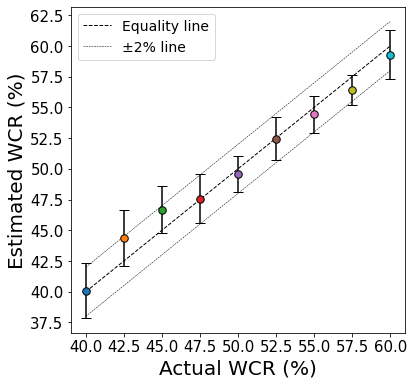

In [12]:
### Plot graph

x_axis = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]
y_axis = [37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(figsize=(6, 6))

for i, tmp_color in enumerate(colors):
    ax.errorbar(WC_name_tag[i], flattened_mean[i], yerr=flattened_std[i], linestyle='None', markeredgecolor='k', ecolor='k', marker='o', markersize=7.5, color=tmp_color, capsize=5, elinewidth=1.5)

# equal line
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], c='k', ls='--', lw=1, label='Equality line')

# upper line
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [42, 44.5, 47, 49.5, 52, 54.5, 57, 59.5, 62], c='k', ls='--', lw=0.5, label='±2% line')

# under lone
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [38, 40.5, 43, 45.5, 48, 50.5, 53, 55.5, 58], c='k', ls='--', lw=0.5)

plt.xlabel('Actual WCR (%)', fontdict={'size': 20})
plt.ylabel('Estimated WCR (%)', fontdict={'size': 20})
plt.xticks(x_axis, fontsize=15)
plt.yticks(y_axis, fontsize=15)
plt.legend(fontsize=14)

plt.show()